### Import Necessary Module and Set Path 

In [176]:
import sqlite3 as lite
import os
import sys
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from decimal import Decimal
from pyne.material import Material

/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


In [130]:
import analysis as an

In [244]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('one_fuelfab.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [245]:
power_dict = an.get_power_dict(cur)
pow = {'legacy lwrs': power_dict['us_government'], 'lwr': power_dict['lwr_inst'], 'msr': power_dict['rebus_inst']}
an.stacked_bar_chart(pow, timestep, 'Year', 'Net Capacity [GWe]', 'Installed nuclear capacity in the U.S.',
                     'power_plot.png', init_year)

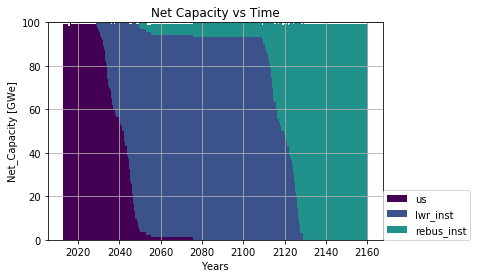

In [246]:
Image('power_plot.png')

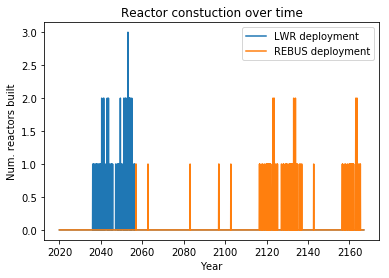

Total deployed:
lwr: 84
rebus: 95


In [248]:
# total lwrs and msrs deployed

lwrs = cur.execute('SELECT entertime, lifetime/lifetime from agententry where prototype = "lwr"').fetchall()
rebus = cur.execute('SELECT entertime, lifetime/lifetime from agententry where prototype = "rebus"').fetchall()
lwrs = an.get_timeseries(lwrs, duration, False)
rebus = an.get_timeseries(rebus, duration, False)
years = 2020 + np.arange(0, duration)/12
plt.plot(years, lwrs, label='LWR deployment')
plt.plot(years, rebus, label='REBUS deployment')
plt.xlabel('Year')
plt.ylabel('Num. reactors built')
plt.legend()
plt.title('Reactor constuction over time')
plt.savefig('us_dep.png', format='png')
plt.show()

print('Total deployed:')
print('lwr:', sum(lwrs))
print('rebus:', sum(rebus))

In [249]:
from pyne import nucname
def get_tru_massfrac(commodity):
    commodity_qualid = cur.execute('SELECT qualid FROM transactions INNER JOIN resources ON '
                                   'resources.resourceid = transactions.resourceid WHERE '
                                   'commodity = "%s"' %commodity).fetchone()[0]
    massfracs = cur.execute('SELECT nucid, massfrac FROM compositions where qualid = %s' %str(commodity_qualid)).fetchall()
    comp_dict = {}
    for row in massfracs:
        if int(row['nucid']) < 930000000 or int(row['nucid']) > 970000000:
            continue
        key = nucname.name(row['nucid'])
        comp_dict[key] = row['massfrac']
    return comp_dict

In [250]:
def get_massfrac(commodity):
    commodity_qualid = cur.execute('SELECT qualid FROM transactions INNER JOIN resources ON '
                                   'resources.resourceid = transactions.resourceid WHERE '
                                   'commodity = "%s"' %commodity).fetchone()[0]
    massfracs = cur.execute('SELECT nucid, massfrac FROM compositions where qualid = %s' %str(commodity_qualid)).fetchall()
    comp_dict = {}
    for row in massfracs:
        key = nucname.name(row['nucid'])
        comp_dict[key] = row['massfrac']
    return comp_dict

In [251]:
import math
def nansum_dict(dictionary):
    tot = 0
    for key, val in dictionary.items():
        if math.isnan(val):
            continue
        tot += val
    return tot

In [252]:
def tru_massfrac_to_vector(comp_dict):
    tot = sum(comp_dict.values())
    for key, val in comp_dict.items():
        comp_dict[key] = val / tot
    return comp_dict

In [253]:
# TRU composition in Spent and initial Fuels:
lwr_unf_tru_comp = get_tru_massfrac('uox_waste')
init_salt_tru_comp = get_tru_massfrac('init_fuel')
eol_salt_tru_comp = get_tru_massfrac('fuel_out')

In [254]:
# TRU Composition
string = 'Isotope & Beginning of Life & End of Life \\\ \n'
for key, val in eol_salt_tru_comp.items():
    if val < 1e-04:
        continue
    string += key + ' & '
    try:
        bol_comp = init_salt_tru_comp[key]
    except:
        bol_comp = 0
    string += '%.2E' % Decimal(str(bol_comp)) + ' & '
    string += '%.2E' % Decimal(str(val)) + '\\\ \n'

string += 'Total & ' + str(sum(init_salt_tru_comp.values())) + ' & ' + str(sum(eol_salt_tru_comp.values())) + ' \\\ \n'
print(string)

Isotope & Beginning of Life & End of Life \\ 
Np237 & 4.55E-03 & 5.93E-04\\ 
Pu238 & 1.74E-03 & 1.90E-03\\ 
Pu239 & 5.71E-02 & 5.21E-02\\ 
Pu240 & 1.98E-02 & 2.82E-02\\ 
Pu241 & 3.37E-03 & 3.29E-03\\ 
Pu242 & 4.61E-03 & 4.00E-03\\ 
Am241 & 3.19E-03 & 1.63E-03\\ 
Am243 & 2.71E-04 & 1.23E-03\\ 
Cm244 & 7.95E-04 & 1.05E-03\\ 
Cm245 & 6.75E-05 & 2.79E-04\\ 
Cm246 & 8.60E-06 & 1.32E-04\\ 
Total & 0.09550070073265847 & 0.09454567570593689 \\ 



In [255]:
lwr_unf_tru_vec = tru_massfrac_to_vector(lwr_unf_tru_comp)
init_salt_tru_vec = tru_massfrac_to_vector(init_salt_tru_comp)
eol_salt_tru_vec = tru_massfrac_to_vector(eol_salt_tru_comp)

print(lwr_unf_tru_vec)
print(init_salt_tru_vec)
print(eol_salt_tru_vec)

{'Np237': 0.04730891560586033, 'Pu238': 0.022637142727796017, 'Pu239': 0.47107005808831404, 'Pu240': 0.2256725335415319, 'Pu241': 0.13652178893365427, 'Pu242': 0.06708826924103727, 'Pu244': 2.2248857792867743e-06, 'Am241': 0.005003469136455384, 'Am242M': 6.627286296835367e-05, 'Am243': 0.01540723912331845, 'Cm242': 0.002011327807452964, 'Cm243': 5.98765538193152e-05, 'Cm244': 0.00664903038124026, 'Cm245': 0.000444355896302929, 'Cm246': 5.6658871363617076e-05, 'Cm247': 7.766089989535045e-07, 'Cm248': 5.973410615802391e-08, 'Cm250': 3.3245151906201296e-16}
{'Np237': 0.047694674074704346, 'Np238': 3.1547272998811375e-12, 'Np239': 2.4474266707031783e-09, 'Np240': 7.412727783286107e-18, 'Pu238': 0.018233523192184523, 'Pu239': 0.5980201067700567, 'Pu240': 0.20701633286070506, 'Pu241': 0.035311239406065065, 'Pu242': 0.04826525540574554, 'Pu243': 4.406018586348782e-17, 'Pu244': 5.129170626197411e-06, 'Pu246': 2.8704079479690376e-22, 'Am241': 0.03338640393104139, 'Am242': 2.2566782426777774e-10

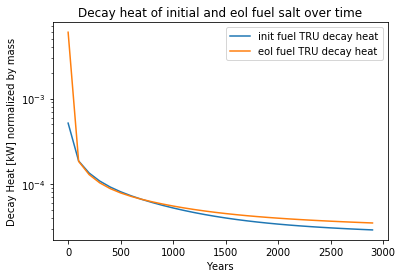

In [256]:
# compare decay heat / activity of init and final fuel
init_salt_mat = Material(init_salt_tru_vec) * 132659000 * 0.095598353
eol_salt_mat = Material(eol_salt_tru_vec) * 132659000 * 0.09552035
years = np.arange(0, 3000, 100)
init_decay_heat = np.zeros(len(years))
eol_decay_heat = np.zeros(len(years))
for indx, year in enumerate(years):
    sec = year * 365 * 24 * 3600
    decayed_init_mat = init_salt_mat.decay(sec)
    decayed_eol_mat = eol_salt_mat.decay(sec)
    init_decay_heat[indx] = nansum_dict(decayed_init_mat.decay_heat()) * 1e-3
    eol_decay_heat[indx] = nansum_dict(decayed_eol_mat.decay_heat()) * 1e-3

plt.semilogy(years, init_decay_heat, label='init fuel TRU decay heat')
plt.semilogy(years, eol_decay_heat, label='eol fuel TRU decay heat')
plt.xlabel('Years')
plt.ylabel('Decay Heat [kW] normalized by mass')
plt.title('Decay heat of initial and eol fuel salt over time')
plt.legend()
plt.show()

In [257]:
# TRU vector
string = 'Isotope & Beginning of Life & End of Life \\\ \n'
for key, val in eol_salt_tru_vec.items():
    if val < 1e-04:
        continue
    string += key + ' & '
    try:
        bol_comp = init_salt_tru_vec[key]
    except:
        bol_comp = 0
    string += '%.2E' % Decimal(str(bol_comp)) + ' & '
    string += '%.2E' % Decimal(str(val)) + '\\\ \n'

print(string)

Isotope & Beginning of Life & End of Life \\ 
Np237 & 4.77E-02 & 6.27E-03\\ 
Np239 & 2.45E-09 & 5.46E-04\\ 
Pu238 & 1.82E-02 & 2.01E-02\\ 
Pu239 & 5.98E-01 & 5.51E-01\\ 
Pu240 & 2.07E-01 & 2.98E-01\\ 
Pu241 & 3.53E-02 & 3.48E-02\\ 
Pu242 & 4.83E-02 & 4.23E-02\\ 
Am241 & 3.34E-02 & 1.72E-02\\ 
Am243 & 2.84E-03 & 1.31E-02\\ 
Cm242 & 4.73E-07 & 6.96E-04\\ 
Cm244 & 8.33E-03 & 1.11E-02\\ 
Cm245 & 7.07E-04 & 2.95E-03\\ 
Cm246 & 9.01E-05 & 1.39E-03\\ 
Cm247 & 1.24E-06 & 2.06E-04\\ 



In [258]:
lwr_unf_tru_comp = get_tru_massfrac('uox_waste')
init_salt_tru_comp = get_tru_massfrac('init_fuel')
eol_salt_tru_comp = get_tru_massfrac('fuel_out')

In [259]:
# French UOX UNF total, in sink, and reprocessed
agent_ids = an.get_agent_ids(cur, 'Reactor')
uox_waste = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'], True, True)
print('US UNF UOX generated in 2013-2050: %f' %uox_waste['uox_waste'][439])


US UNF UOX generated in 2013-2050: 78281.510000


In [260]:
agent_ids = an.get_agent_ids(cur, 'Source')
legacy_waste = an.facility_commodity_flux(cur, agent_ids, ['pre_2013_unf'], True, True)
print('US legacy UOX UNF in 2013: %f' %legacy_waste['pre_2013_unf'][1])


US legacy UOX UNF in 2013: 68072.030000


In [261]:
agent_ids = an.get_prototype_id(cur, 'reprocessing')
us_rep = an.facility_commodity_flux(cur, agent_ids, ['cooled_uox', 'pre_2013_unf'], False, True)
print('US UNF reprocesed up until 2050: %f' %(us_rep['cooled_uox'][439] + us_rep['cooled_uox'][439]))


US UNF reprocesed up until 2050: 128974.696000


In [262]:
total_unf = uox_waste['uox_waste'][439] + legacy_waste['pre_2013_unf'][1]
print('TOTAL UOX UNF inventory in US in 2050: %f' %total_unf)

TOTAL UOX UNF inventory in US in 2050: 146353.540000


Total init salt mass sent to MSRs: 0.000000


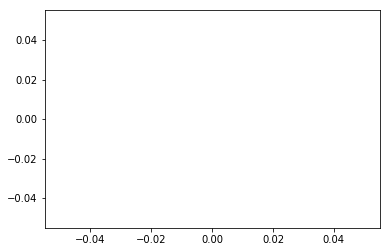

In [263]:
# Salt created
agent_ids = an.get_agent_ids(cur, 'Source')
init_salt = an.facility_commodity_flux(cur, agent_ids, ['init_fuel'], True, False)
print('Total init salt mass sent to MSRs: %f' %sum(init_salt['init_fuel']))
plt.plot(init_salt['init_fuel'])

Total TRU extracted: 0 MTHM of TRU


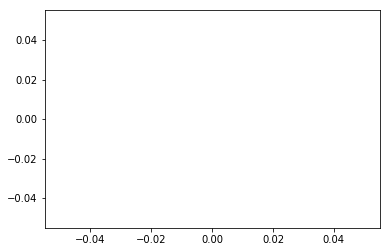

In [264]:
# reprocessed TRU -> LWR UNF
init_salt_tru = np.array(init_salt['init_fuel']) * (sum(init_salt_tru_comp.values()))
plt.plot(init_salt_tru)
print('Total TRU extracted:', sum(init_salt_tru), 'MTHM of TRU')

Total LWR UNF reprocessed: 0 MTHM


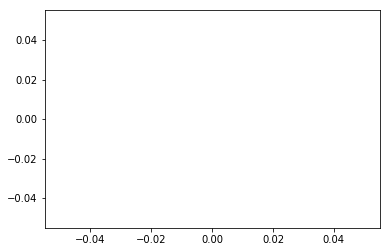

In [265]:
lwr_unf_reprocessed = init_salt_tru / sum(lwr_unf_tru_comp.values())
plt.plot(lwr_unf_reprocessed)
print('Total LWR UNF reprocessed:', sum(lwr_unf_reprocessed), 'MTHM')

In [266]:
# average reprocessing
avg_monthly_rep = sum(lwr_unf_reprocessed) / 1433
print('Average monthly reprocessing of LWR UNF:', avg_monthly_rep, 'MTHM/month from 2040')

Average monthly reprocessing of LWR UNF: 0.0 MTHM/month from 2040


In [267]:
# LWR UNF leftover after reprocessing:
leftover = total_unf - sum(lwr_unf_reprocessed)
print(leftover, 'MTHM of LWR UNF')

146353.53999999998 MTHM of LWR UNF


In [268]:
# average salt fab
avg_monthly_fab = sum(init_salt['init_fuel']) / 1433
print('Average monthly fabrication of fuel salt:', avg_monthly_fab, 'MTHM/month from 2040')


Average monthly fabrication of fuel salt: 0.0 MTHM/month from 2040


In [269]:
# Total reprocessed U stockpile
agent_ids = an.get_agent_ids(cur, 'Sink')
repu = an.facility_commodity_flux(cur, agent_ids, ['lwr_u', 'salt_u'], False, True)
total_repu = max(repu['lwr_u']) + max(repu['salt_u'])
print('Total reprocessed uranium stockpile: %f' %max(total_repu))

TypeError: 'numpy.float64' object is not iterable

In [ ]:
# Total Raffinate
raff = an.facility_commodity_flux(cur, agent_ids, ['reprocess_waste', 'salt_reprocess_waste'], False, True)
total_raff = max(raff['reprocess_waste']) + max(raff['salt_reprocess_waste'])
print('Total raffinate stockpile: %f' %max(total_raff))

In [ ]:
# Waste from MSR
waste = an.facility_commodity_flux(cur, agent_ids, ['waste'], False, False)
plt.plot(waste['waste'])
tot_waste = sum(waste['waste'])
print('Total waste from MSRs: %f' %tot_waste + ' MTHM')

In [ ]:
# Tails accumulation
agent_ids = an.get_agent_ids(cur, 'Enrichment')
tails = an.facility_commodity_flux(cur, agent_ids, ['tails'], True, False)
tails_accum = sum(tails['tails'])
print('Total tails: %f' %tails_accum)

# Tails usage
for_init_salt = sum(init_salt['init_fuel']) * 0.477050824

# or storage
agent_ids = an.get_agent_ids(cur, 'Source')
fill = an.facility_commodity_flux(cur, agent_ids, ['dep_u'], True, False)
for_fill_commod = sum(fill['dep_u'])
tot = for_init_salt + for_fill_commod
print('Total tails used = (for init salt) + (for fill commod)')
print('Total tails used = %f + %f = %f' %(for_init_salt, for_fill_commod, tot))

# total outstanding tails
print('Total outstanding tails inventory = %f' %(tails_accum - tot))

In [ ]:
# Natural U used until 2050
source = an.nat_u_timeseries(cur)
print('Total natural U: %f' %max(source))

# ====================================

In [ ]:
# get total fuel mass vs time plot up until 2050
fuel_dict = an.fuel_usage_timeseries(cur, ['uox'], True)
fuel_dict['uox'] = fuel_dict['uox']
an.stacked_bar_chart(fuel_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'Total LWR Fuel Mass vs Time',
                  'total_fuel',
                  init_year)

In [59]:
# get astrid fuel discharge vs time plot
storageids = an.get_agent_ids(cur, 'storage')
astrid_discharge = an.facility_commodity_flux(cur, storageids, ['astrid_unf'], False, False)
an.stacked_bar_chart(astrid_discharge, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID UNF discharge vs Time',
                  'astrid_unf',
                  init_year)

In [60]:
# where does the astrid fuel come from?
init_year, init_month, duration, timestep = an.get_timesteps(cur)

agent_ids = an.get_agent_ids(cur, 'Reactor')
astrid_loading = an.facility_commodity_flux(cur, agent_ids, ['astrid_fuel_legacy', 'astrid_fuel_new'], False, False)

print('Total ASTRID fuel from spent UOX:')
print(sum(astrid_loading['astrid_fuel_legacy']))
print('Total ASTRID fuel from spent ASTRID fuel:')
print(sum(astrid_loading['astrid_fuel_new']))

Total ASTRID fuel from spent UOX:
17795.32799999986
Total ASTRID fuel from spent ASTRID fuel:
57790.27199999988


In [61]:
import collections
new_dict = collections.OrderedDict()
new_dict = {'fuel from used uox': astrid_loading['astrid_fuel_legacy'],
            'fuel from used mox': astrid_loading['astrid_fuel_new']}
an.stacked_bar_chart(new_dict, timestep,
                  'Years', 'Mass[MTHM]',
                  'ASTRID Fuel Loading vs Time',
                  'where_fuel',
                  init_year)


In [62]:
# cum plutonium flux
agent_ids = an.get_agent_ids(cur, 'separations')
pu = an.facility_commodity_flux(cur, agent_ids, ['lwr_pu', 'sfr_pu'], True, False)
pu['pu from legacy'] = pu.pop('lwr_pu')
pu['pu from spent sfr fuel'] = pu.pop('sfr_pu')
an.stacked_bar_chart(pu, timestep, 'Years', 'Mass [MTHM]', 'Total Pu Mass vs Time', 'pu', init_year)

print('Total Pu from Spent UOX:')
print(sum(pu['pu from legacy']))
print('Total Pu from Spent ASTRID Fuel:')
print(sum(pu['pu from spent sfr fuel']))
print('Total Pu Reprocessed:')
print(sum(pu['pu from spent sfr fuel']) + sum(pu['pu from legacy']))


Total Pu from Spent UOX:
2669.9276880810953
Total Pu from Spent ASTRID Fuel:
19883.9008139658
Total Pu Reprocessed:
22553.828502046894


In [31]:
# Total Reprocessed Uranium Stockpile
agent_ids = an.get_agent_ids(cur, 'sink')
repu_inv = an.facility_commodity_flux(cur, agent_ids, ['uox_U', 'astrid_U'], False, True)
an.stacked_bar_chart(repu_inv, timestep, 'Years', 'Mass[MTHM]', 'Total Rep U Mass vs Time', 'repu', init_year)

print('Total Reprocessed U Inventory:')
print(max([x+y for x, y in zip(repu_inv['uox_U'], repu_inv['astrid_U'])]))

Total Reprocessed U Inventory:
159383.763159


In [32]:
# Raffinate
agent_ids = an.get_agent_ids(cur, 'separations')
reprocess_waste = an.facility_commodity_flux(cur, agent_ids, ['lahague_raffinate', 'uox_raffinate', 'astrid_raffinate'], True, False)
an.stacked_bar_chart(reprocess_waste, timestep, 'Years', 'Mass [MTHM]',
                     'Raffinate Inventory vs Time', 'raffinate', init_year)
print('Total Raffinate:')
print(sum([x+y+z for x, y, z in zip(reprocess_waste['lahague_raffinate'], reprocess_waste['uox_raffinate'], reprocess_waste['astrid_raffinate']
)]))

Total Raffinate:
24789.4271143


In [33]:
# get spent fuel no_cum and cumulative plot
agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict_no_cum = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, False)
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'],
                                        False, True) 
dictionary = {}
dictionary['monthly_discharge'] = snf_dict_no_cum['uox_waste'][:960]
dict2 = {}
dict2['cum_mass'] = snf_dict['uox_waste'][:960]

an.double_axis_bar_line_plot(dictionary,dict2, timestep[:960], 'Years',  'Monthly Discharge Mass [MTHM]','Cumulative Mass [MTHM]',
                    'Spent Fuel Discharge vs Time', 'snf_discharge', init_year)

agent_ids = an.get_agent_ids(cur, 'Storage')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['uox_waste', 'french_uox_waste'],
                                        False)
print('Total UOX Waste in MTHM:')
print(max([x + y for x, y in zip(snf_dict['uox_waste'], snf_dict['french_uox_waste'])]))
print('Total UOX Waste Stored:')
print(max(snf_dict['uox_waste']))
agent_ids = an.get_agent_ids(cur, 'Sink')
snf_dict = an.facility_commodity_flux(cur, agent_ids, ['mox_waste'],
                                        False)
print('Total MOX Waste in MTHM:')
print(max(snf_dict['mox_waste']))

Total UOX Waste in MTHM:
176640.413
Total UOX Waste Stored:
110045.923
Total MOX Waste in MTHM:
6945.558


In [34]:
# Display important simulation results

# natural uranium demand
dictionary = collections.OrderedDict()
dictionary['natural_uranium'] = an.nat_u_timeseries(cur)
print('Total Natural U in MTHM:')
print(max(dictionary['natural_uranium']))

# get spent fuel timeseries separated by region

agent_ids = an.get_agent_ids(cur, 'Storage')
comm_dict = an.commodity_flux_region(cur, agent_ids, ['uox_waste', 'french_uox_waste'], False)

# get fuel usage timeseries in stacked bar chart
fuel_dict = an.fuel_usage_timeseries(cur, ['uox', 'mox'])

print('Total UOX usage in MTHM:')
print(max(fuel_dict['uox']))
print('Total MOX usage in MTHM:')
print(max(fuel_dict['mox']))

# get tailings timeseries
agent_ids = an.get_agent_ids(cur, 'Storage')
tails_dict = an.facility_commodity_flux(cur, agent_ids, ['tails'], False)
print('Total Tailings in MTHM:')
print(max(tails_dict['tails']))

print('Finished!')

Total Natural U in MTHM:
1246226.87843
Total UOX usage in MTHM:
176640.413
Total MOX usage in MTHM:
6945.558
Total Tailings in MTHM:
1069586.46543
Finished!


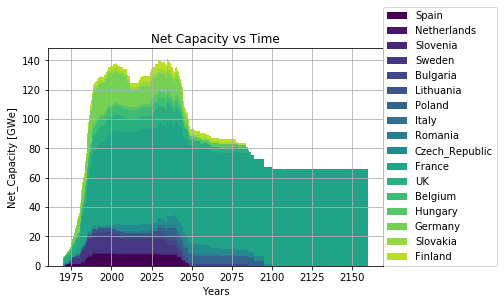

In [233]:
# Display Net Capacity vs Time
from IPython.display import Image
Image(filename='power_plot.png')

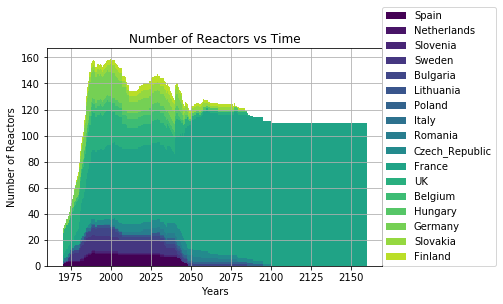

In [197]:
# Display Number of Reactors vs Time
from IPython.display import Image
Image(filename='num_plot.png')

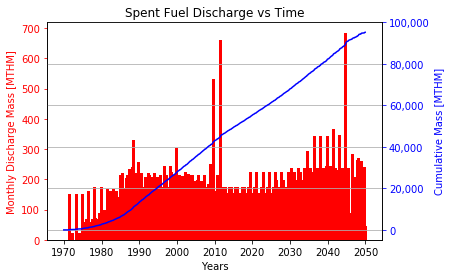

In [198]:
# Display natural U demand  vs Time
from IPython.display import Image
Image(filename='cum_mass_snf_discharge.png')

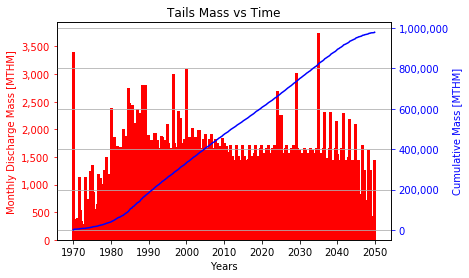

In [199]:
# Display spent fuel vs Time
from IPython.display import Image
Image(filename='tails_tailings.png')

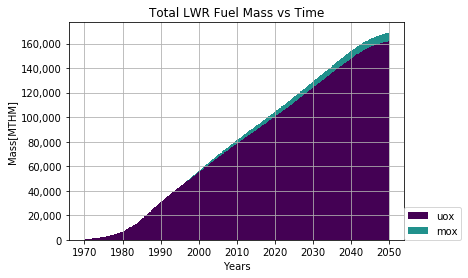

In [200]:
# Display total fuel usage  vs Time
from IPython.display import Image
Image(filename='total_fuel.png')